# Import the dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

from matplotlib import pyplot as plt

import sys
import time

sys.path.append("../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

In [2]:
epochs = 50
onehot_dims = 4
maxlen = 500
num_neurons = 256
filters = 50
kernel_size = 4
pooling_kernel_size = 4

# Load & Prepare the data

In [3]:
enc_dict = {"(": [1.0, .0, .0, .0],
            ")": [.0, 1.0, .0, .0],
            "x": [.0, .0, 1.0, .0],
            "@x.": [.0, .0, .0, 1.0]}
tokens_pattern = r"(\(|\)|@x\.|x)"


def tokenize_data(simplified_term):
    return re.findall(tokens_pattern, simplified_term)


def tokenize_and_vectorize(x_data):
    vectorized_data_ = []
    for sample_ in x_data:
        tokens_ = tokenize_data(sample_)
        sample_vecs_ = []
        for token_ in tokens_:
            try:
                sample_vecs_.append(enc_dict[token_])
            except KeyError:
                pass
        vectorized_data_.append(sample_vecs_)
    return vectorized_data_

In [4]:
all_data = pd.read_csv("../lstm_lo_steps_prediction/data/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_lo that are more than 30
all_data = all_data[[steps_lo < 31 for steps_lo in all_data['steps_num_lo']]]

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

# make test/train split
x_train, x_test, y_train, y_test = train_test_split(all_data["simple_terms"].tolist(), all_data["steps_num_lo"].tolist(),
                                                    test_size=0.2, random_state=42)

print(f"Count training samples: {len(y_train)}")
print(f"Count testing samples: {len(y_test)}")

Count all terms: 4251

Count original terms: 4251

max steps count: 30
min steps count: 0
Count training samples: 2952
Count testing samples: 739


In [5]:
# one-hot encode y-data
encoder = LabelBinarizer()
encoder.fit(range(0, 31))
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

x_train = tokenize_and_vectorize(x_train)
x_test = tokenize_and_vectorize(x_test)

In [6]:
xy_train_data = list(zip(x_train, y_train))
xy_test_data = list(zip(x_test, y_test))

In [7]:
print(f"len(test_data) = {len(xy_test_data)}")
print(f"len(train_data) = {len(xy_train_data)}")

len(test_data) = 739
len(train_data) = 2952


In [8]:
def train_generator():
    while True:
        random.shuffle(xy_train_data)
        for xtd, ytd in xy_train_data:
            yield np.array([xtd]), np.array([ytd])


def val_generator():
    while True:
        for xtd, ytd in xy_test_data:
            yield np.array([xtd]), np.array([ytd])

# Define the model

In [9]:
model = Sequential()

model.add(Conv1D(
    filters=filters,
    kernel_size=kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
    input_shape=(None, onehot_dims)
))

model.add(LSTM(units=num_neurons))
model.add(Dense(units=num_neurons, activation='relu'))
model.add(Dense(units=31, activation='softmax'))


In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 50)          850       
                                                                 
 lstm (LSTM)                 (None, 256)               314368    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 31)                7967      
                                                                 
Total params: 388,977
Trainable params: 388,977
Non-trainable params: 0
_________________________________________________________________


In [11]:
model_structure = model.to_json()
with open("./fine_models/v0_conv_lstm.json", 'w') as json_file:
    json_file.write(model_structure)

In [12]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='./fine_models/v0_conv_lstm.h5',  # Specify the path to save the best model
    monitor='val_accuracy',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

In [13]:
history = model.fit(train_generator(), steps_per_epoch=2952, validation_data=val_generator(), validation_steps=739, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/50
2952/2952 [==============================] - 65s 20ms/step - loss: 2.9917 - accuracy: 0.1043 - val_loss: 2.9582 - val_accuracy: 0.1096
Epoch 2/50
2952/2952 [==============================] - 54s 18ms/step - loss: 2.9233 - accuracy: 0.0989 - val_loss: 2.9029 - val_accuracy: 0.1015
Epoch 3/50
2952/2952 [==============================] - 51s 17ms/step - loss: 2.7022 - accuracy: 0.1430 - val_loss: 2.5566 - val_accuracy: 0.1732
Epoch 4/50
2952/2952 [==============================] - 49s 17ms/step - loss: 2.4635 - accuracy: 0.1829 - val_loss: 2.4366 - val_accuracy: 0.2043
Epoch 5/50
2952/2952 [==============================] - 51s 17ms/step - loss: 2.2962 - accuracy: 0.2371 - val_loss: 2.3529 - val_accuracy: 0.2558
Epoch 6/50
2952/2952 [==============================] - 50s 17ms/step - loss: 2.2357 - accuracy: 0.2476 - val_loss: 2.2542 - val_accuracy: 0.2490
Epoch 7/50
2952/2952 [==============================] - 50s 17ms/step - loss: 2.1980 - accuracy: 0.2693 - val_loss: 2.1694 -

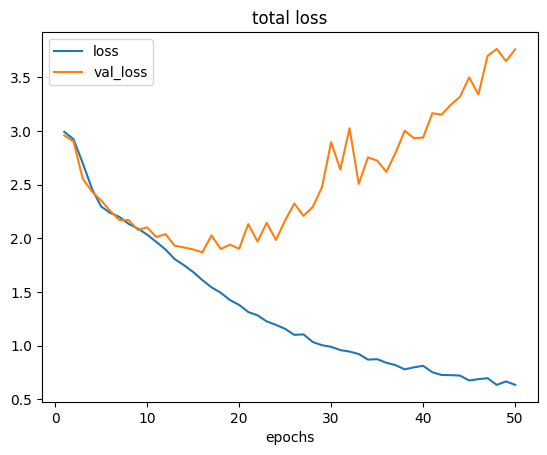

In [14]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

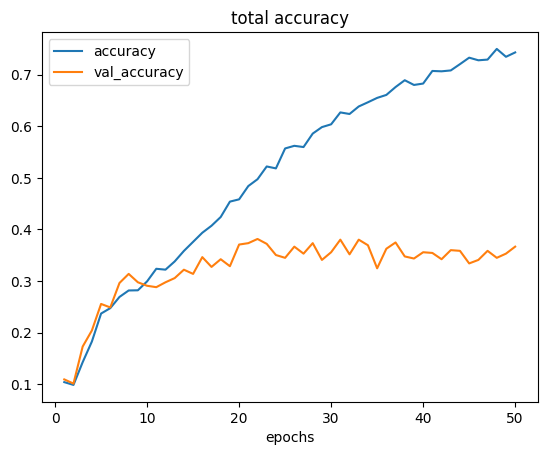

In [15]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("total accuracy")

plt.legend()
plt.show()

In [16]:
def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()


def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy

100%|██████████| 739/739 [00:52<00:00, 13.97it/s]


Test accuracy: 0.36671177266576455


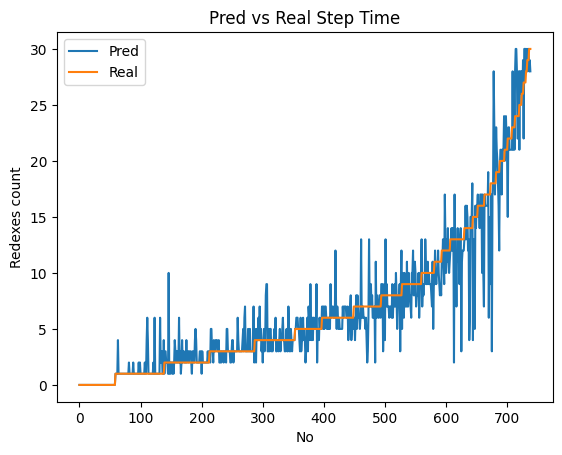

In [17]:
y_test_pred = []
for x_ in tqdm(x_test):
    y_test_pred.append(model.predict(np.array([x_]), verbose=0)[0])


y_test_pred_nums = encoder.inverse_transform(np.array(y_test_pred))
y_test_nums = encoder.inverse_transform(y_test)

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
draw_pred_lines(y_test_pred_nums, y_test_nums)

100%|██████████| 2952/2952 [03:10<00:00, 15.50it/s]


Train accuracy: 0.7831978319783198


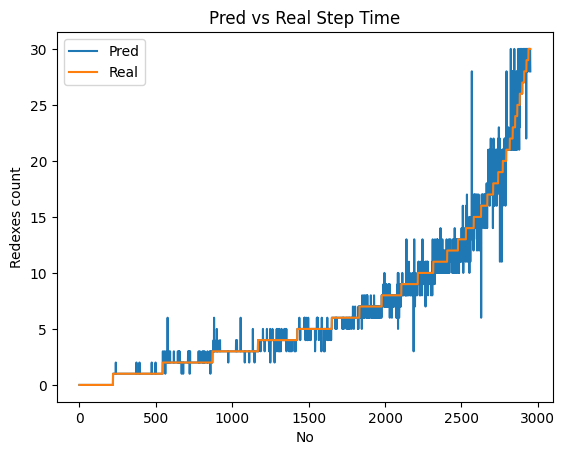

In [18]:
y_train_pred = []
for x_ in tqdm(x_train):
    y_train_pred.append(model.predict(np.array([x_]), verbose=0)[0])


y_train_pred_nums = encoder.inverse_transform(np.array(y_train_pred))
y_train_nums = encoder.inverse_transform(y_train)

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
draw_pred_lines(y_train_pred_nums, y_train_nums)

In [ ]:
def ite_term():
    x, y, c = Var(), Var(), Var()
    x_, y_, c_ = Atom(x), Atom(y), Atom(c)
    return Lambda(c, Lambda(x, Lambda(y, multi_app_term(c_, x_, y_))))


def true_term():
    x, y = Var(), Var()
    x_ = Atom(x)
    return Lambda(x, Lambda(y, x_))


def num_zero_term():
    s, z = Var(), Var()
    z_ = Atom(z)
    return Lambda(s, Lambda(z, z_))


def num_term(n: int):
    if n <= 0:
        return num_zero_term()
    s, z = Var(), Var()
    s_, z_ = Atom(s), Atom(z)
    core_term = App(s_, z_)
    for _ in range(n - 1):
        core_term = App(s_, core_term)
    return Lambda(s, Lambda(z, core_term))


def multi_app_term(term_0: Term, term_1: Term, *terms: Term):
    res_app_term = App(term_0, term_1)
    for term in terms:
        res_app_term = App(res_app_term, term)
    return res_app_term


def false_term():
    x, y = Var(), Var()
    y_ = Atom(y)
    return Lambda(x, Lambda(y, y_))


def pair_term():
    x, y, p = Var(), Var(), Var()
    x_, y_, p_ = Atom(x), Atom(y), Atom(p)
    return Lambda(x, Lambda(y, Lambda(p, multi_app_term(p_, x_, y_))))


def first_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, true_term()))


def second_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, false_term()))


def succ_term():
    x, y, n = Var(), Var(), Var()
    x_, y_, n_ = Atom(x), Atom(y), Atom(n)
    return Lambda(n, Lambda(x, Lambda(y, App(x_, multi_app_term(n_, x_, y_)))))


def sinc_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(
        p,
        multi_app_term(
            pair_term(),
            App(second_term(), p_),
            App(succ_term(), App(second_term(), p_)),
        ),
    )


def pred_term():
    n, f, x, g, h, u = Var(), Var(), Var(), Var(), Var(), Var()
    n_, f_, x_ = Atom(n), Atom(f), Atom(x)
    g_, h_, u_ = Atom(g), Atom(h), Atom(u)

    return Lambda(n, Lambda(f, Lambda(x, multi_app_term(
        n_,
        Lambda(g, Lambda(h, App(h_, App(g_, f_)))),
        Lambda(u, x_),
        Lambda(u, u_)
    ))))


def plus_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(m, Lambda(n, multi_app_term(n_, succ_term(), m_)))


def subtract_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(n, Lambda(m, multi_app_term(m_, pred_term(), n_)))


def iszero_term():
    x, n = Var(), Var()
    n_ = Atom(n)
    return Lambda(n, App(App(n_, Lambda(x, false_term())), true_term()))


def leq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n, Lambda(m, App(iszero_term(), multi_app_term(subtract_term(), n_, m_)))
    )


def and_term():
    a, b = Var(), Var()
    a_, b_ = Atom(a), Atom(b)
    return Lambda(a, Lambda(b, multi_app_term(ite_term(), a_, b_, a_)))


def eq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n,
        Lambda(
            m,
            multi_app_term(
                and_term(),
                multi_app_term(leq_term(), n_, m_),
                multi_app_term(leq_term(), m_, n_),
            ),
        ),
    )


def i_term():
    x = Var()
    x_ = Atom(x)
    return Lambda(x, x_)


def omega_term(n: int):
    x = Var()
    x_ = Atom(x)
    body_app_term = x_
    for _ in range(n - 1):
        body_app_term = App(body_app_term, x_)
    return Lambda(x, body_app_term)


def multi_i_term(m: int):
    app_term = i_term()
    for _ in range(m - 1):
        app_term = App(app_term, i_term())
    return app_term


def omega_multi_i_term(n: int, m: int):
    return App(omega_term(n), multi_i_term(m))


def term_test_1():
    x, y = Var(), Var()
    x_, y_ = Atom(x), Atom(y)

    return "(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x", \
        App(
            Lambda(x, Lambda(y, y_)),
            App(
                Lambda(x, App(x_, x_)),
                Lambda(x, App(x_, x_))
            )
        )


def term_test_2():
    return "(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(ite_term(), true_term(), num_term(3), num_term(1))


def term_test_3():
    return "(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(ite_term(), false_term(), num_term(0), num_term(4))


def term_test_4():
    return "(PRED 0) == 0 == λx. λy. y", \
        multi_app_term(pred_term(), num_term(0))


def term_test_5():
    return "(PRED 5) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(pred_term(), num_term(5))


def term_test_6():
    return "(PLUS 0 0) == 0 == λx. λy. y", \
        multi_app_term(plus_term(), num_term(0), num_term(0))


def term_test_7():
    return "(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))", \
        multi_app_term(plus_term(), num_term(2), num_term(3))


def term_test_8():
    return "(SUBTRACT 4 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(subtract_term(), num_term(4), num_term(1))


def term_test_9():
    return "(SUBTRACT 3 5) == 0 == λx. λy. y", \
        multi_app_term(subtract_term(), num_term(3), num_term(5))


def term_test_10():
    return "(LEQ 3 2) == FALSE == λx. λy. y", \
        multi_app_term(leq_term(), num_term(3), num_term(2))


def term_test_11():
    return "(LEQ 2 5) == TRUE == λx. λy. x", \
        multi_app_term(leq_term(), num_term(2), num_term(5))


def term_test_12():
    return "(EQ 2 2) == TRUE == λx. λy. x", \
        multi_app_term(eq_term(), num_term(2), num_term(2))


def term_test_13():
    return "(EQ 1 4) == FALSE == λx. λy. y", \
        multi_app_term(eq_term(), num_term(1), num_term(4))


def term_test_14():
    return "Omega(3, 3)  == I == λx. x", \
        omega_multi_i_term(3, 3)


def term_test_15():
    return "GCD_vO 5 2", \
        multi_app_term(gcd_term_v0(), num_term(5), num_term(2))


def term_test_16():
    return "GCD_v1 5 2", \
        multi_app_term(gcd_term_v1(), num_term(5), num_term(2))


def term_test_17():
    return "GCD_v3 5 2", \
        multi_app_term(gcd_term_v3(), num_term(5), num_term(2))


def term_test_18():
    return "PYTHAGOREAN 5 2 2", \
        multi_app_term(
            pythagorean_term(), num_term(5), num_term(2), num_term(2)
        )


def test_function(term_deskr_: str, term_: Term, model_: Sequential):
    prediction_ = model_.predict(np.array(pad_trunk(tokenize_and_vectorize([term_.simple_str()]))), verbose=0)
    print(f"{term_deskr_}\nnorm_steps={term_.normalize(LOStrategy())[1]}\tpred_steps={np.argmax(prediction_[0])}\n")


list_test_functions = (term_test_1, term_test_2, term_test_3, term_test_4, term_test_5, term_test_6, term_test_7, term_test_9, term_test_10, term_test_11, term_test_12, term_test_13, term_test_14, term_test_15, term_test_16, term_test_17, term_test_18)

for term_function in list_test_functions:
    term_deskr, term = term_function()
    test_function(term_deskr, term, model)

In [ ]:
list_simplified_omega_terms = []

for n in range(1, 21):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        list_simplified_omega_terms.append(term_.simple_str())

list_simplified_omega_terms = pad_trunk(tokenize_and_vectorize(list_simplified_omega_terms))

real_redexes_count = []

for n in tqdm(range(1, 21)):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        real_redexes_count.append(term_.normalize(LOStrategy())[1])

predictions_omega_terms_redexes = []
for rec_ in tqdm(list_simplified_omega_terms):
    predictions_omega_terms_redexes.append(np.argmax(model.predict([rec_], verbose=0)[0]))

In [ ]:
print(predictions_omega_terms_redexes)

In [ ]:
print(real_redexes_count)

In [ ]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


print("Test accuracy:", calculate_accuracy(real_redexes_count, predictions_omega_terms_redexes))

In [ ]:
green_dots = []
red_dots = []

for n in range(0, 20):
    for m in range(0, 20):
        val = predictions_omega_terms_redexes[n * 20 + m]
        val_real = real_redexes_count[n * 20 + m]

        if val == val_real:
            green_dots.append((n+1, m+1))
        else:
            red_dots.append((n+1, m+1))


In [ ]:
plt.figure(figsize=(12, 12))

green_dots = np.array(green_dots)
red_dots = np.array(red_dots)

plt.scatter(green_dots[:,0], green_dots[:,1], s=5, c='green',)
plt.scatter(red_dots[:,0], red_dots[:,1], s=5, c='red',)

plt.xlabel("n", fontsize=18)
plt.ylabel("m", fontsize=18)
plt.title("Omega(n, m)", fontsize=20)
plt.show()

# Do additional metrics testing

## Mean Squared Error

In [ ]:
mse_train = mean_squared_error(y_train_nums, y_train_pred_nums)
print("Train {Mean Squared Error}:", mse_train)

mse_test = mean_squared_error(y_test_nums, y_test_pred_nums)
print("Test {Mean Squared Error}:", mse_test)

## Mean Absolute Error

In [19]:
mae_train = mean_absolute_error(y_train_nums, y_train_pred_nums)
print("Train {Mean Absolute Error}:", mae_train)

mae_test = mean_absolute_error(y_test_nums, y_test_pred_nums)
print("Test {Mean Absolute Error}:", mae_test)

Train {Mean Absolute Error}: 0.3333333333333333
Test {Mean Absolute Error}: 1.2354533152909337


## Mean Absolute Percentage Error

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    percentage_errors = np.abs((y_true - y_pred) / y_true_fix) * 100
    mape = np.mean(percentage_errors)
    return mape


mape_train = mean_absolute_percentage_error(y_train_nums, y_train_pred_nums)
print("Train {Mean Absolute Percentage Error}:", mape_train)

mape_test = mean_absolute_percentage_error(y_test_nums, y_test_pred_nums)
print("Test {Mean Absolute Percentage Error}:", mape_test)

## Percentage of Explained Variance (PEV)

In [ ]:
# Calculate Variance of the target variable
variance_y_test = np.var(y_test_nums)
variance_y_train = np.var(y_train_nums)

# Calculate Percentage of Explained Variance (PEV)
pev_test = (1 - mse_test / variance_y_test) * 100
pev_train = (1 - mse_train / variance_y_train) * 100

print("Train {Percentage of Explained Variance}:", pev_train)
print("Test {Percentage of Explained Variance}:", pev_test)

## Mean Bias Deviation

In [ ]:
def mean_bias_deviation(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    n = len(y_true)
    mbd = np.sum((y_pred - y_true) / y_true_fix) * 100 / n
    return mbd


mbd_train = mean_bias_deviation(y_train_nums, y_train_pred_nums)
print("Train {Mean Bias Deviation}:", mbd_train)

mdb_test = mean_bias_deviation(y_test_nums, y_test_pred_nums)
print("Test {Mean Bias Deviation}:", mdb_test)

## Coefficient of Correlation (Pearson's r)

In [ ]:
coc_test = np.corrcoef(y_test_pred_nums, y_test_nums)[0, 1]
coc_train = np.corrcoef(y_train_pred_nums, y_train_nums)[0, 1]

print("Train {Mean Bias Deviation}:", coc_train)
print("Test {Mean Bias Deviation}:", coc_test)

## Error STD

In [ ]:
y_train_cl_pred_nums = np.array(y_train_pred_nums)
y_test_cl_pred_nums = np.array(y_test_pred_nums)

y_train_nums = np.array(y_train_nums)
y_test_nums = np.array(y_test_nums)
train_error = y_train_nums - y_train_cl_pred_nums
test_error = y_test_nums - y_test_cl_pred_nums
print("Train Error STD:", np.abs(train_error).std())
print("Test Error STD:", np.abs(test_error).std())

In [ ]:
def advanced_point_drawer(y_real, y_pred, title="Train dataset"):
    counter = Counter([(x_, y_) for x_, y_ in zip(y_real, y_pred)])
    coords_count = dict(counter)

    plt.figure(figsize=(12, 12))

    coords_count_rev = dict()
    for key_, val_ in coords_count.items():
        if val_ not in coords_count_rev:
            coords_count_rev[val_] = []
        coords_count_rev[val_].append(key_)

    tcoords_count_rev = dict()
    for key_ in sorted(coords_count_rev.keys()):
        tcoords_count_rev[key_] = coords_count_rev[key_]

    coords_count_rev = tcoords_count_rev

    for key_, val_ in coords_count_rev.items():
        coords_data = np.array(val_)
        plt.scatter(coords_data[:, 0], coords_data[:, 1], s=key_ ** 1 + 5, c='tab:blue', label=f"\n{key_}\n")

    plt.plot([0, 31], [0, 31], c="gray", linestyle="--")
    plt.axis("equal")
    plt.xlabel("Real", fontsize=18)
    plt.ylabel("Predict", fontsize=18)
    plt.title(title, fontsize=20)
    plt.legend(prop={'size': 10})
    plt.show()

In [ ]:
advanced_point_drawer(y_train_nums, y_train_cl_pred_nums)

In [ ]:
advanced_point_drawer(y_test_nums, y_test_cl_pred_nums)